In [22]:
from json import load
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.ndimage import label

DIRPATH = './maps/example_maps_v4_waffle_counter_clockwise'
MAP_001 = 'map_20250330_222348_568341.json'
ESTIMATED_COLOR = 200

VAL_UNKNOWN = -1
VAL_FREE = 0
VAL_OCCUPIED = 100

colormap = {
    VAL_UNKNOWN: [0.5, 0.5, 0.5],  # Gray (unknown terrain)
    VAL_FREE: [1.0, 1.0, 1.0],  # White (blank space)
    VAL_OCCUPIED: [0.0, 0.0, 0.0],  # Black (walls)
    ESTIMATED_COLOR: [0.0, 1.0, 0.0]  # Green (estimated walls)
}

# val_free = 0
# val_occupied = 100
# val_unknown = -1

In [23]:
def read_data(_dir_path: str=DIRPATH, _map_path: str=MAP_001) -> tuple[np.ndarray[tuple[()], np.dtype], int, int]:
    _data = dict()
    with open(_dir_path + '/' + _map_path, 'r+') as json_data:
        _data = load(json_data)
        json_data.close()
        
    print(_data)

    width = _data['info']['width']
    height = _data['info']['height']
    _data = _data['data']

    grid = np.array(_data).reshape((height, width))

    return grid, height, width

def print_plot(grid: np.ndarray[tuple[()], np.dtype], height: int, width: int, title: str="Original map") -> None:
    colored_map = np.zeros((height, width, 3))
    for y in range(height):
        for x in range(width):
            color_code = grid[y, x]
            colored_map[y, x] = colormap[color_code]
            
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(colored_map, origin='upper')
    plt.title(title)
    plt.axis('off')
    
    return

{'header': {'stamp': {'sec': 1365, 'nanosec': 980000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.944586618085908, 'y': -2.5808939351719564, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1, 100, 100, 100, 100, 100, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 1

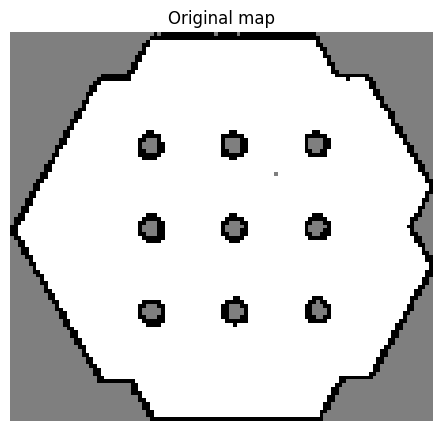

In [24]:
print(*read_data())

print_plot(*read_data())

In [25]:
def fill_enclosed_unknowns(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    # Identify all accessible -1 regions using flood fill from edges
    accessible = np.zeros_like(grid, dtype=bool)
    queue = []
    
    # Start flood fill from the borders where -1 is found
    for i in range(height):
        if grid[i, 0] == VAL_UNKNOWN:
            queue.append((i, 0))
        if grid[i, width - 1] == VAL_UNKNOWN:
            queue.append((i, width - 1))
    for j in range(width):
        if grid[0, j] == VAL_UNKNOWN:
            queue.append((0, j))
        if grid[height - 1, j] == VAL_UNKNOWN:
            queue.append((height - 1, j))
    
    while queue:
        x, y = queue.pop()
        if accessible[x, y] or grid[x, y] != -1:
            continue
        accessible[x, y] = True
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width and grid[nx, ny] == VAL_UNKNOWN:
                queue.append((nx, ny))
    
    # Any VAL_UNKNOWN not marked as accessible is enclosed and should be converted to 100
    filled_grid[(grid == VAL_UNKNOWN) & (~accessible)] = VAL_OCCUPIED
    
    return filled_grid

{'header': {'stamp': {'sec': 1365, 'nanosec': 980000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.944586618085908, 'y': -2.5808939351719564, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1, 100, 100, 100, 100, 100, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, 100, 100, 1

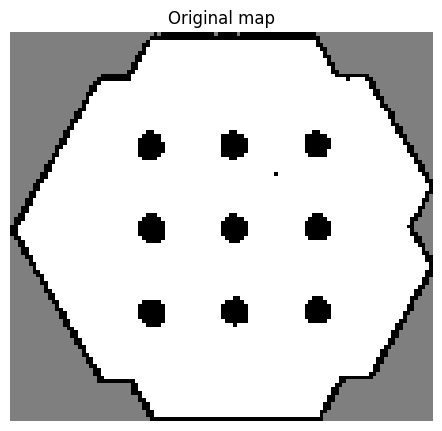

In [26]:
_grid, _height, _width = read_data()
_grid = fill_enclosed_unknowns(_grid)

print_plot(_grid, _height, _width)

In [27]:
def calculate_remaining_space(grid: np.ndarray[tuple[()], np.dtype]) -> None:

    _explored_num = np.count_nonzero(grid==100) + np.count_nonzero(grid==0)
    print(_width, _height, _width*_height, _explored_num)
    _explored_percent = _explored_num / (_width * _height)
    print('explored %f not explored %f', _explored_percent, 1.0-_explored_percent)
    
    return

calculate_remaining_space(grid=_grid)

112 103 11536 8753
explored %f not explored %f 0.7587552011095701 0.24124479889042993


112 103 11536 23
explored %f not explored %f 0.00199375866851595 0.9980062413314841


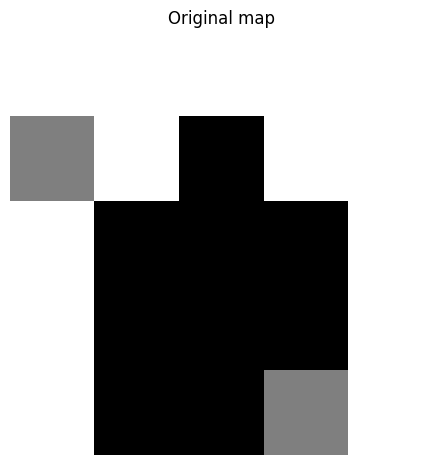

In [28]:
test_grid = np.array([
    [0,   0,    0,    0, 0],
    [-1, 0, 100, 0, 0],
    [0, 100,  -1 , 100, 0],
    [0, 100, -1  , 100, 0],
    [0, 100, 100, -1, 0]
])
test_grid = fill_enclosed_unknowns(test_grid)
print_plot(test_grid, 5, 5)

calculate_remaining_space(grid=test_grid)

In [29]:
def fill_boundary_gaps(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if grid[i, j] == -1:
                # Check horizontal filling condition
                if grid[i, j - 1] == 100 and grid[i, j + 1] == 100:
                    filled_grid[i, j] = 100
                # Check vertical filling condition
                elif grid[i - 1, j] == 100 and grid[i + 1, j] == 100:
                    filled_grid[i, j] = 100
    
    return filled_grid


def fill_boundary_unknowns(grid: np.ndarray, max_range: int = 5) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    for i in range(height):
        for j in range(width):
            if grid[i, j] == -1:
                # Check if within max_range from an occupied boundary
                for dx in range(-max_range, max_range + 1):
                    for dy in range(-max_range, max_range + 1):
                        ni, nj = i + dx, j + dy
                        if 0 <= ni < height and 0 <= nj < width and grid[ni, nj] == 100:
                            filled_grid[i, j] = 100
                            break
                    if filled_grid[i, j] == 100:
                        break
    return filled_grid

In [30]:
test_grid = np.array([
    [0,   0,    0,    0, 0],
    [-1, 0, 100, 100, 0],
    [0, 100,  -1 , -1, 0],
    [0, 100, -1  , 100, 0],
    [0, 100, 100, -1, 0]
])

print(fill_boundary_gaps(test_grid))

[[  0   0   0   0   0]
 [ -1   0 100 100   0]
 [  0 100  -1 100   0]
 [  0 100 100 100   0]
 [  0 100 100  -1   0]]


## Try to combine elements together

In [60]:
def fill_enclosed_unknowns_v2(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    # Identify all -1 regions using connected components
    labeled_grid, num_features = label(grid == -1)
    
    # Find which regions are connected to 1 or touch the boundary
    invalid_regions = set()
    for i in range(height):
        for j in range(width):
            if labeled_grid[i, j] > 0:
                # If the region is adjacent to 1, mark it as invalid
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = i + dx, j + dy
                    if 0 <= nx < height and 0 <= ny < width and grid[nx, ny] == VAL_FREE:
                        invalid_regions.add(labeled_grid[i, j])
                # If the region touches the boundary, also mark it as invalid
                if i == 0 or i == height - 1 or j == 0 or j == width - 1:
                    invalid_regions.add(labeled_grid[i, j])
    
    # Convert enclosed unknown regions (only surrounded by 100) to 100
    for region_id in range(1, num_features + 1):
        if region_id not in invalid_regions:
            filled_grid[labeled_grid == region_id] = ESTIMATED_COLOR
    
    return filled_grid

#deprecated
def fill_outside_unknowns_v2(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    # Identify all -1 and 0 regions using connected components
    labeled_grid, num_features = label((grid == -1) | (grid == 0))
    
    # Find which regions are enclosed by 100
    enclosed_regions = set(range(1, num_features + 1))
    for i in range(height):
        for j in range(width):
            if labeled_grid[i, j] > 0:
                # If the region touches the boundary, mark it as not enclosed
                if i == 0 or i == height - 1 or j == 0 or j == width - 1:
                    enclosed_regions.discard(labeled_grid[i, j])
                # If the region is adjacent to a non-100 value, mark it as not enclosed
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = i + dx, j + dy
                    if 0 <= nx < height and 0 <= ny < width and grid[nx, ny] != 100:
                        enclosed_regions.discard(labeled_grid[i, j])
    
    # Convert all -1 values that are outside the enclosed boundary to 100
    for region_id in range(1, num_features + 1):
        if region_id not in enclosed_regions:
            filled_grid[labeled_grid == region_id] = 100
    
    return filled_grid

def is_fully_enclosed(grid: np.ndarray) -> bool:
    height, width = grid.shape
    visited = np.zeros_like(grid, dtype=bool)
    queue = []
    
    # Start flood fill from the borders where 0 or -1 exists
    for i in range(height):
        if grid[i, 0] in (0, -1):
            queue.append((i, 0))
        if grid[i, width - 1] in (0, -1):
            queue.append((i, width - 1))
    for j in range(width):
        if grid[0, j] in (0, -1):
            queue.append((0, j))
        if grid[height - 1, j] in (0, -1):
            queue.append((height - 1, j))
    
    while queue:
        x, y = queue.pop()
        if visited[x, y] or grid[x, y] == VAL_OCCUPIED:
            continue
        visited[x, y] = True
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width and not visited[nx, ny] and grid[nx, ny] in (0, -1):
                queue.append((nx, ny))
    
    # If any 0 is reachable from the boundary, it is not enclosed
    return not np.any((grid == VAL_FREE) & visited)

def fill_outside_with_100(grid: np.ndarray) -> np.ndarray:
    filled_grid = grid.copy()
    height, width = grid.shape
    
    # Identify all external areas using flood fill from edges
    visited = np.zeros_like(grid, dtype=bool)
    queue = []
    
    for i in range(height):
        if grid[i, 0] != VAL_OCCUPIED:
            queue.append((i, 0))
        if grid[i, width - 1] != VAL_OCCUPIED:
            queue.append((i, width - 1))
    for j in range(width):
        if grid[0, j] != VAL_OCCUPIED:
            queue.append((0, j))
        if grid[height - 1, j] != VAL_OCCUPIED:
            queue.append((height - 1, j))
    
    while queue:
        x, y = queue.pop()
        if visited[x, y] or grid[x, y] == VAL_OCCUPIED:
            continue
        visited[x, y] = True
        
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < height and 0 <= ny < width and not visited[nx, ny] and grid[nx, ny] != VAL_OCCUPIED:
                queue.append((nx, ny))
    
    # Any non-VAL_OCCUPIED space that is not visited is fully enclosed, so fill the outside with VAL_OCCUPIED
    filled_grid[visited] = ESTIMATED_COLOR
    
    return filled_grid


{'header': {'stamp': {'sec': 1268, 'nanosec': 827000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 80, 'height': 102, 'origin': {'position': {'x': -2.9425274395242393, 'y': -2.5581532864970455, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

/tmp/ipykernel_6695/1282238318.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


False map_20250330_222048_560767.json
111 103 11433 5558
explored %f not explored %f 0.48613662205895214 0.5138633779410479
{'header': {'stamp': {'sec': 1310, 'nanosec': 850000000}, 'frame_id': 'map'}, 'info': {'map_load_time': {'sec': 0, 'nanosec': 0}, 'resolution': 0.05000000074505806, 'width': 112, 'height': 103, 'origin': {'position': {'x': -2.944586618085908, 'y': -2.5808939351719564, 'z': 0.0}, 'orientation': {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}}}, 'data': [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 100, -1, 100, 100, 100, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1, 100, 100, 100, 100, 100, -1, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

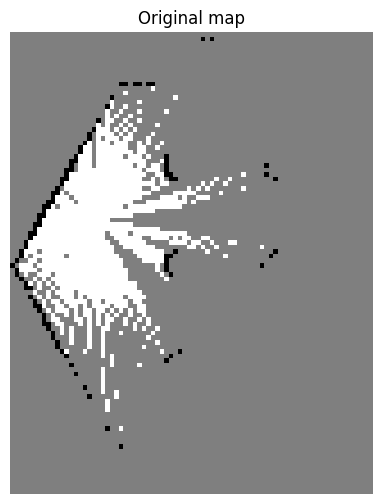

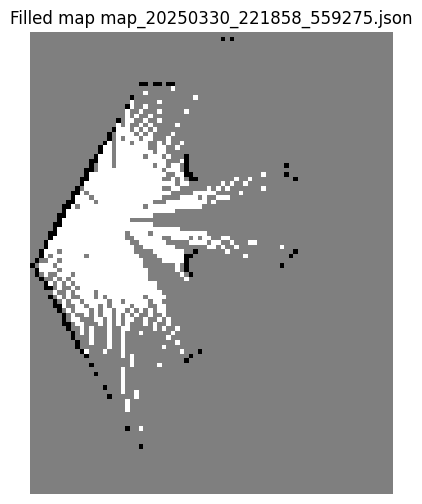

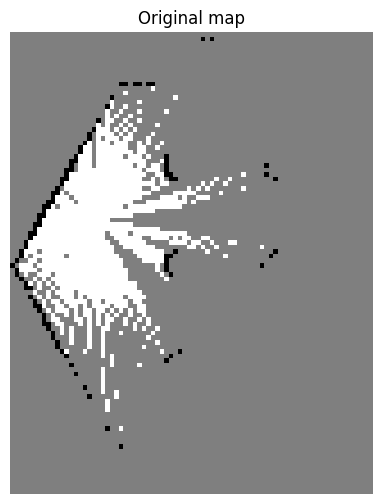

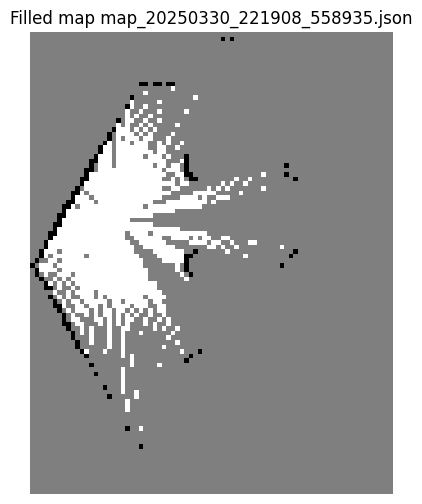

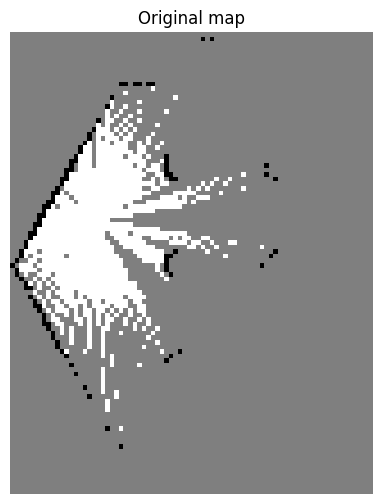

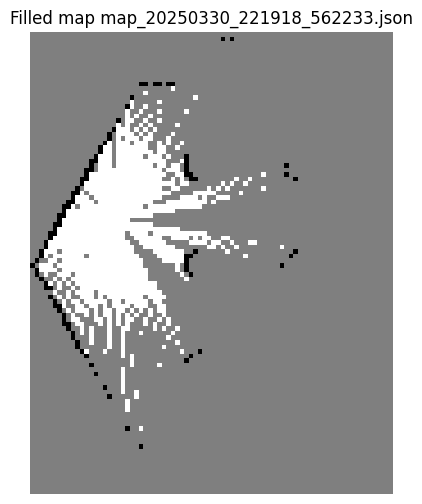

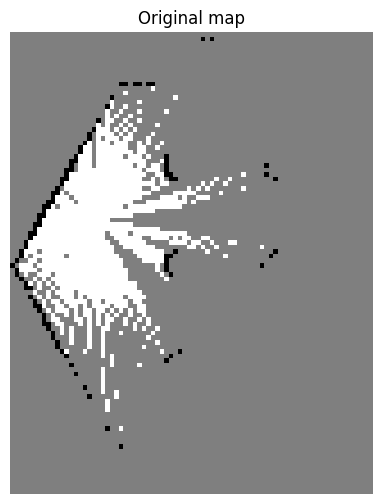

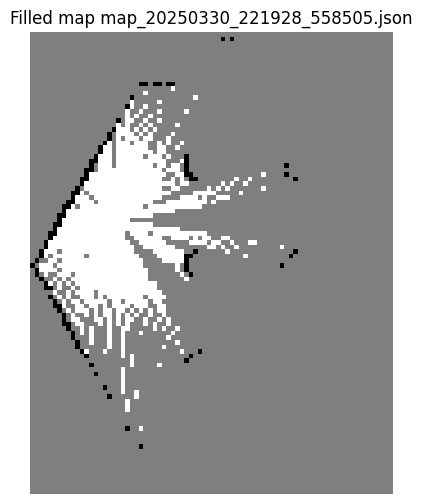

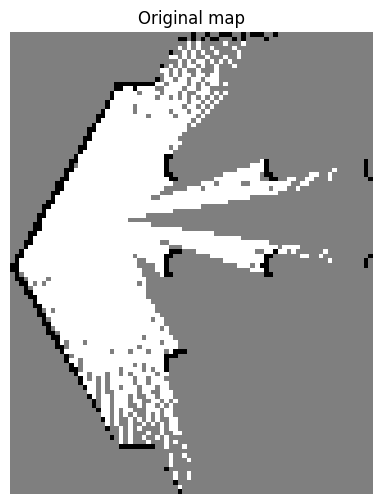

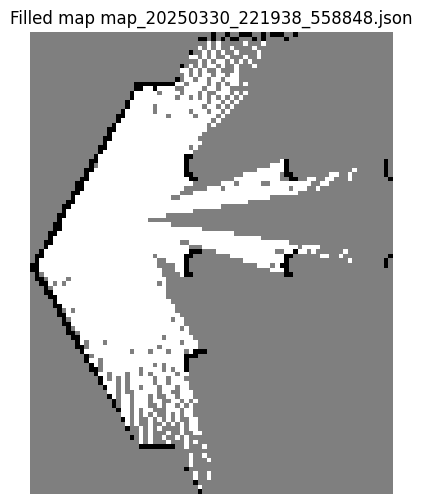

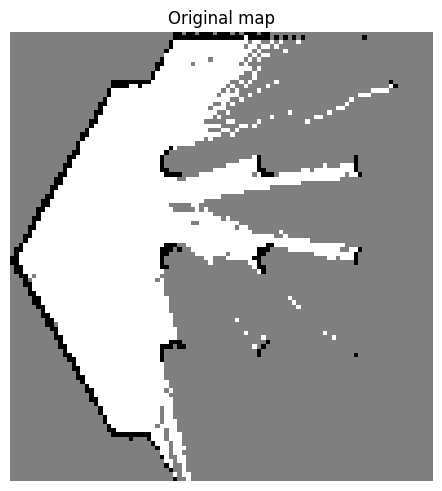

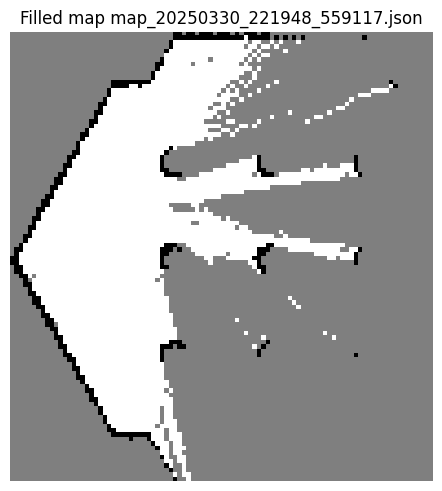

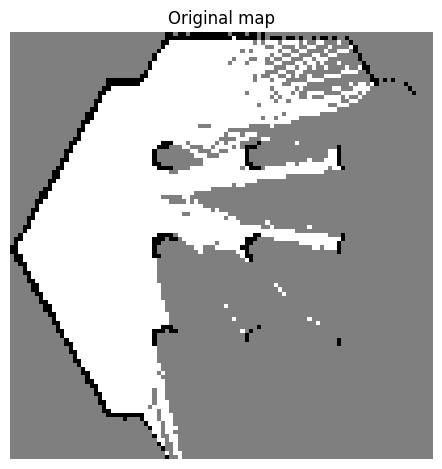

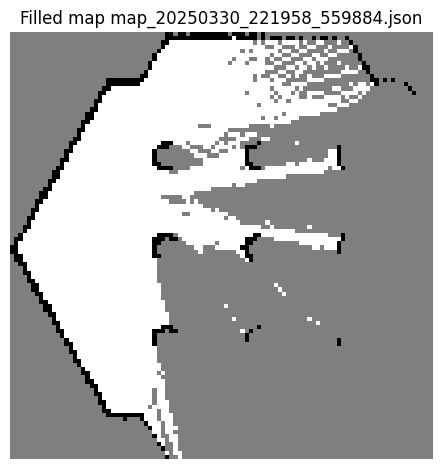

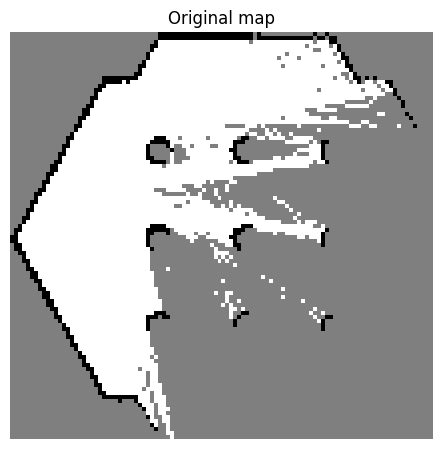

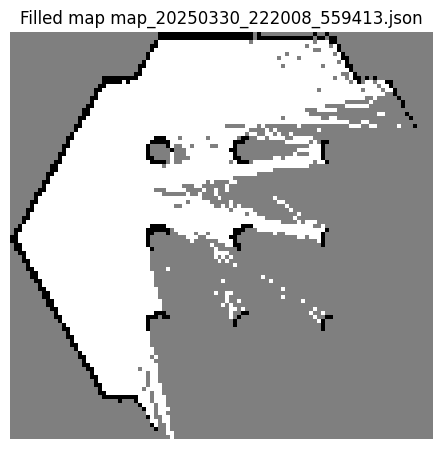

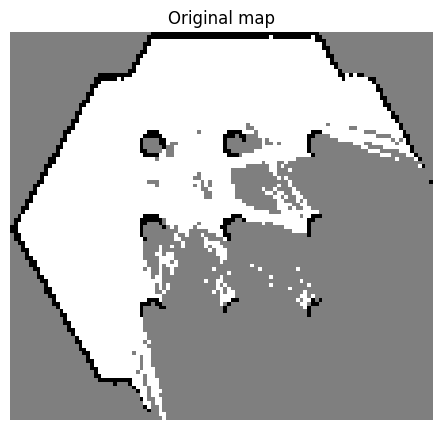

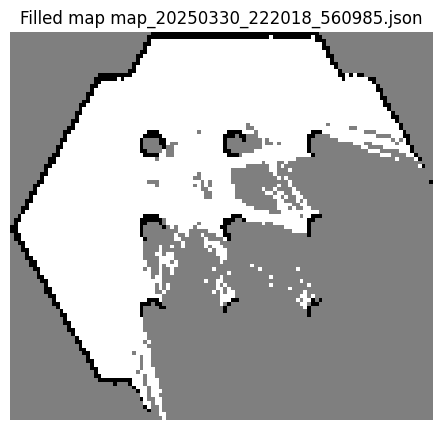

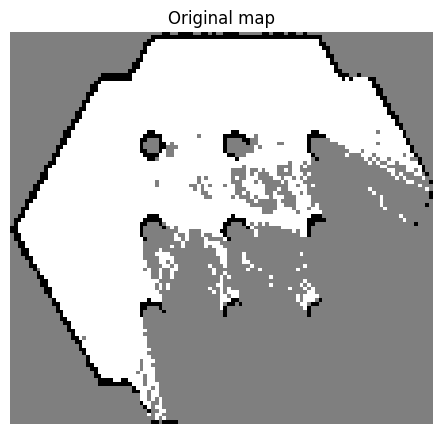

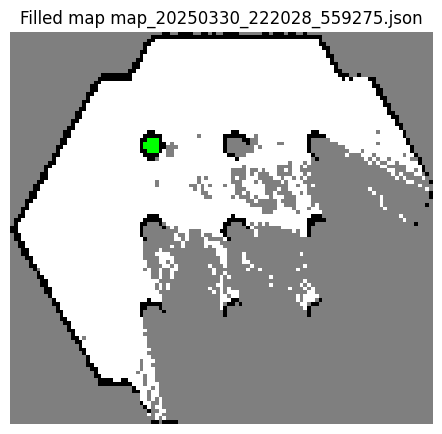

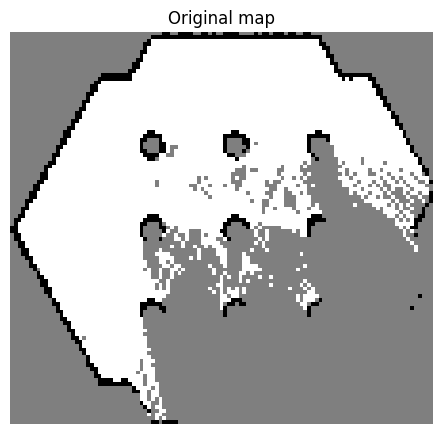

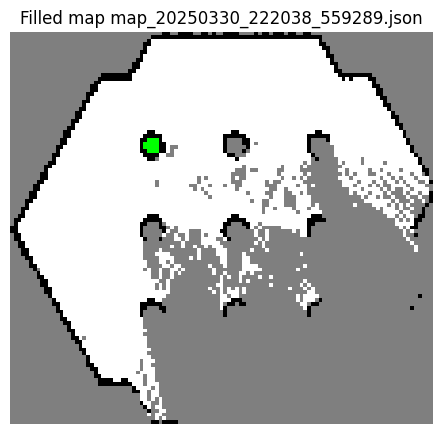

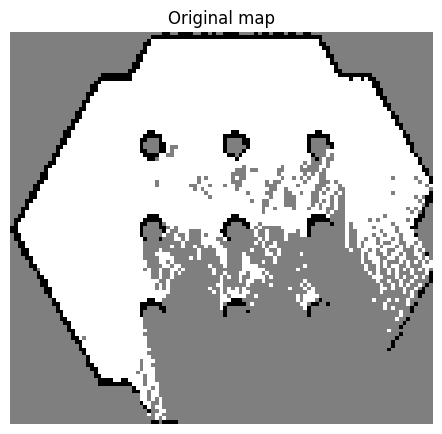

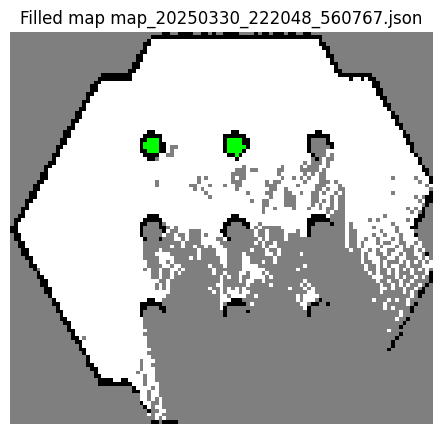

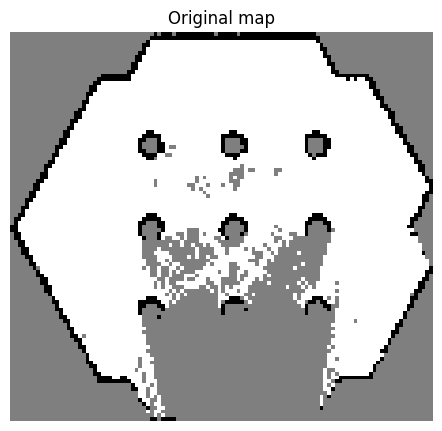

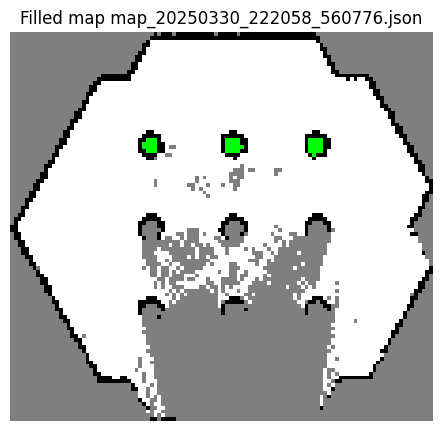

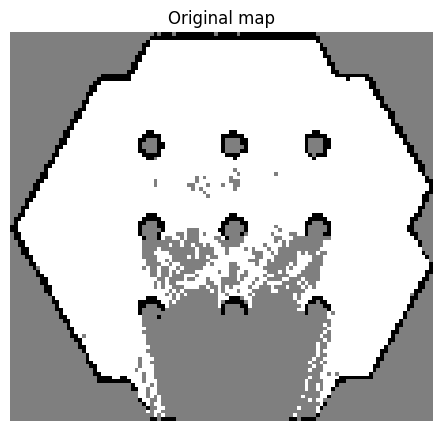

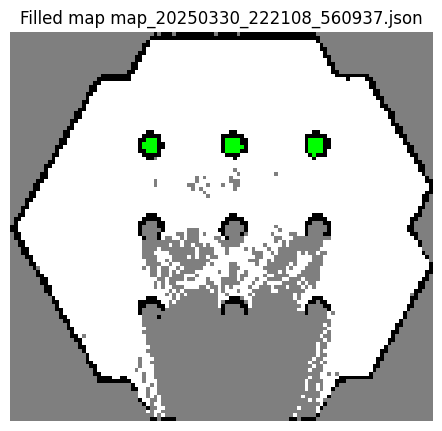

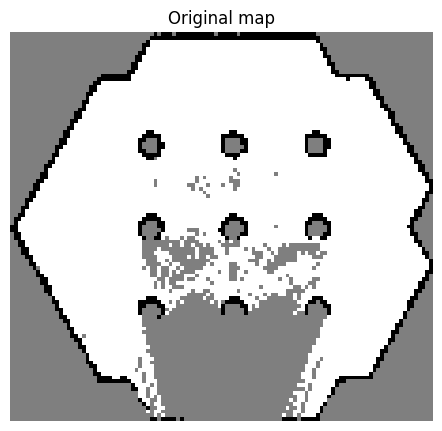

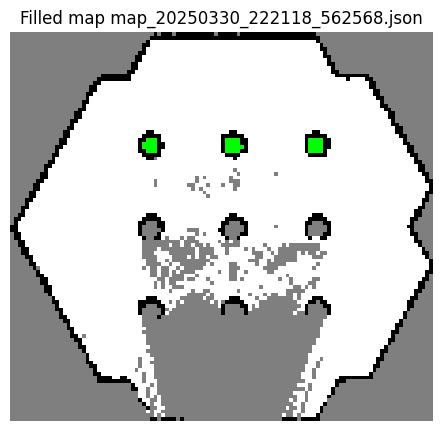

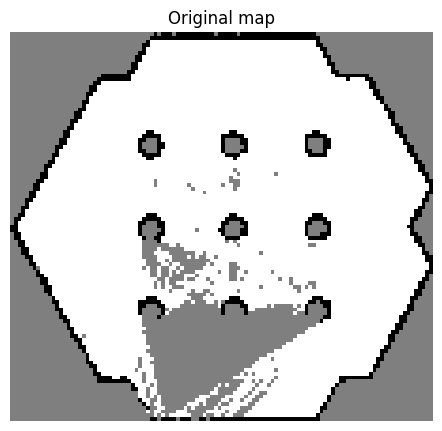

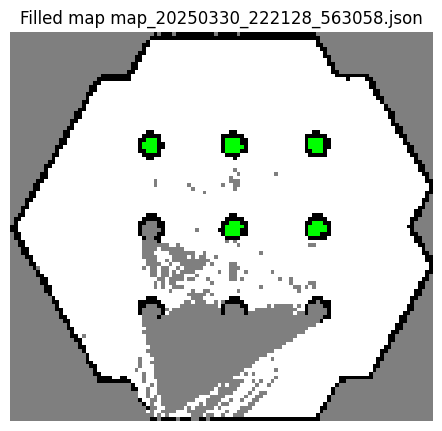

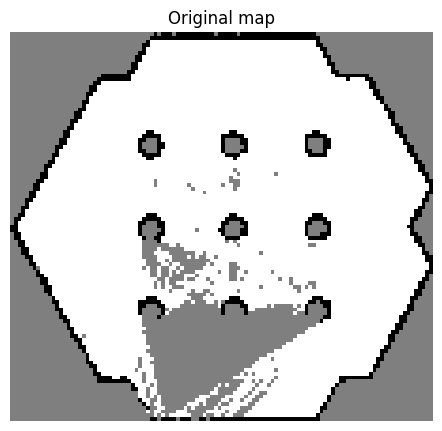

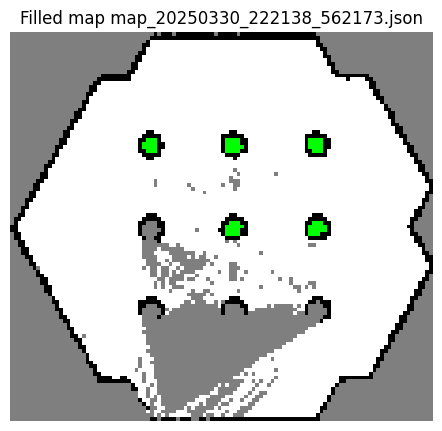

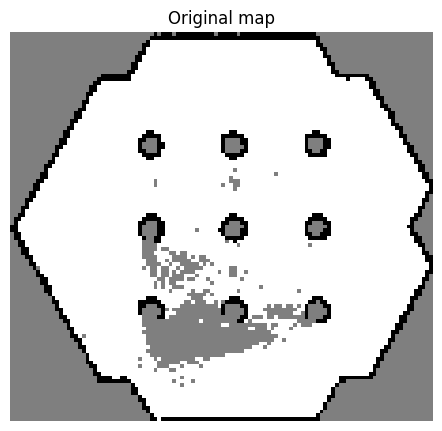

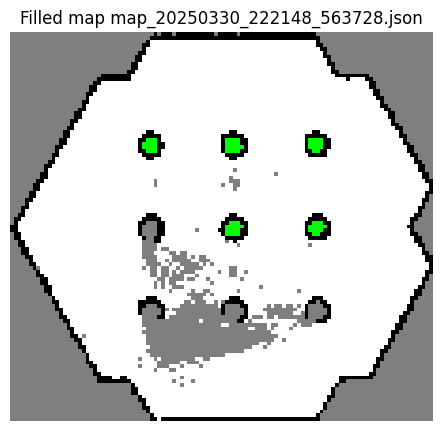

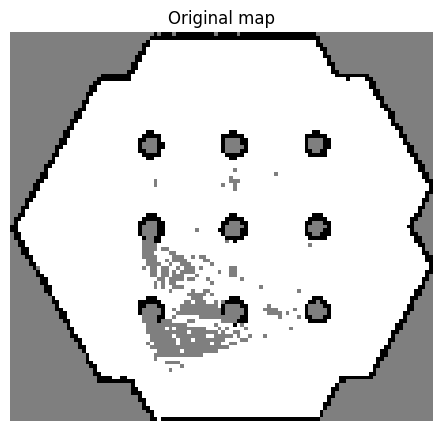

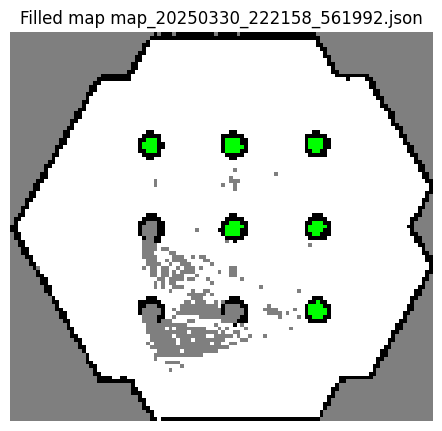

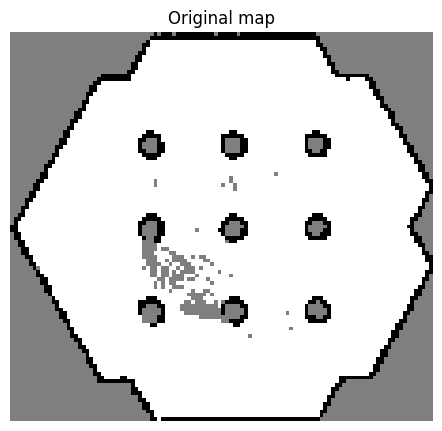

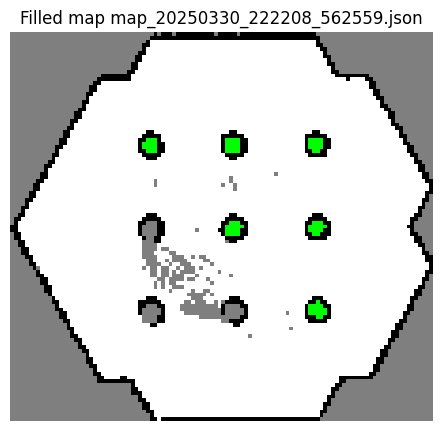

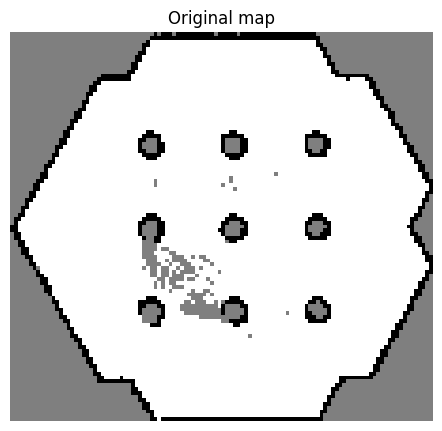

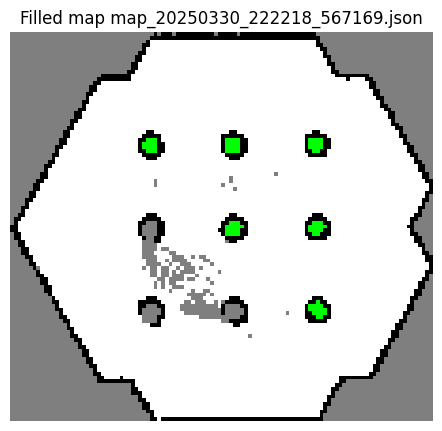

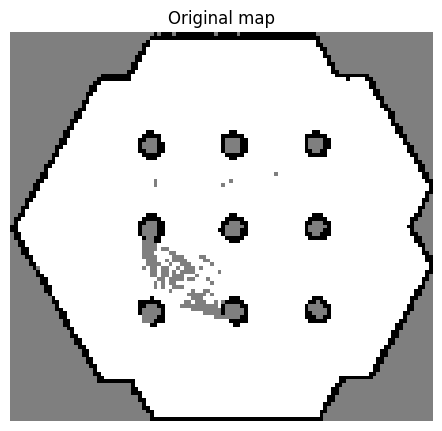

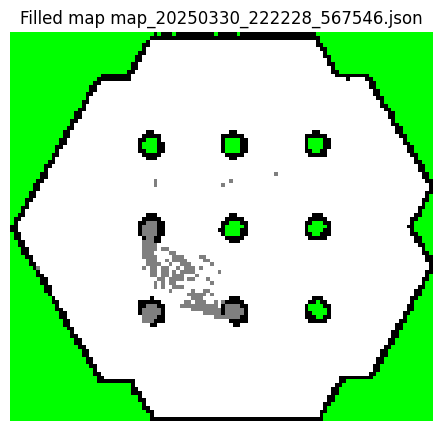

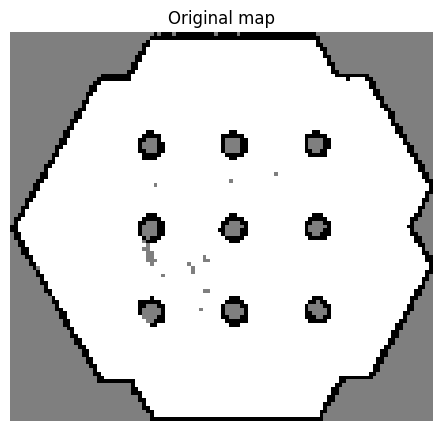

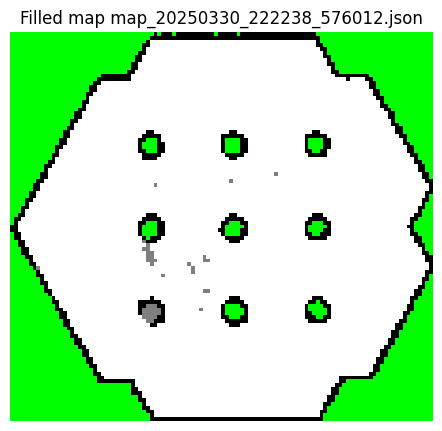

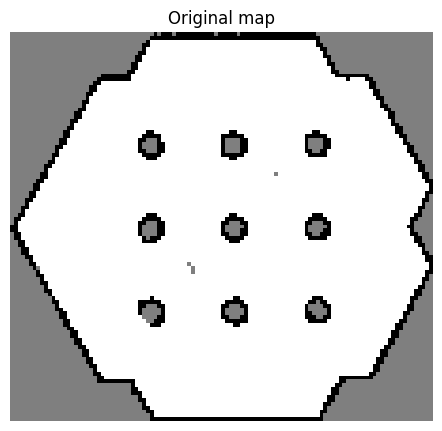

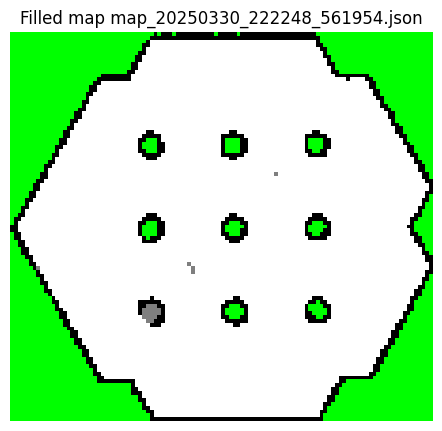

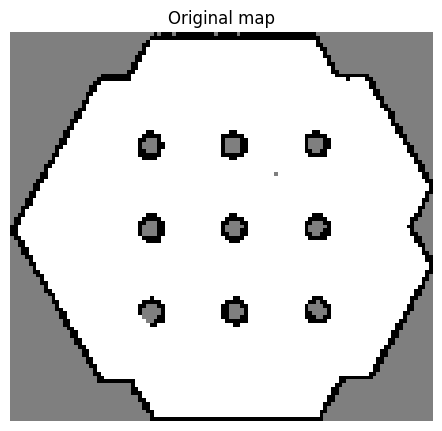

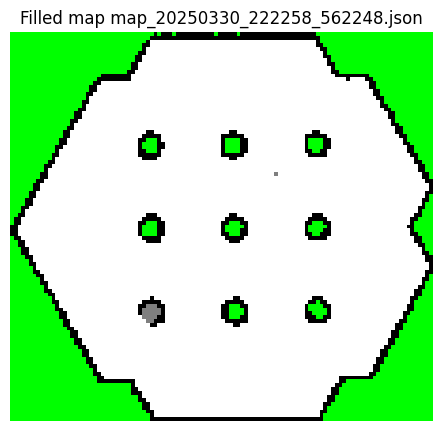

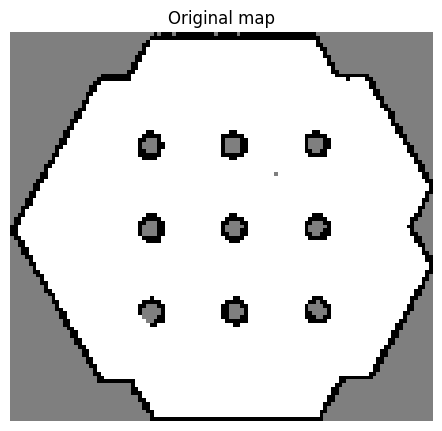

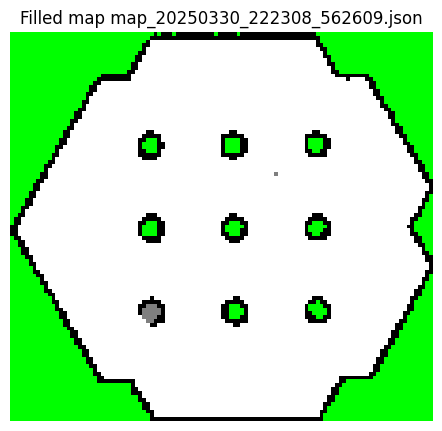

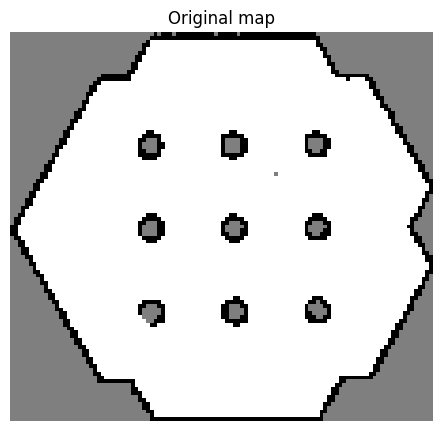

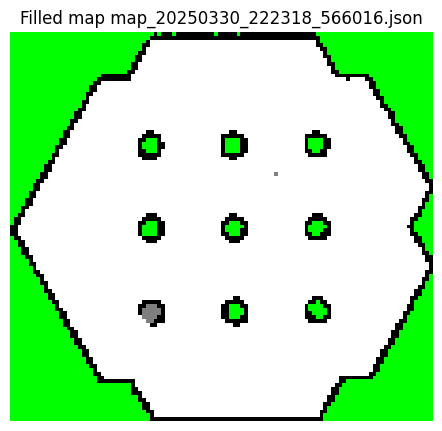

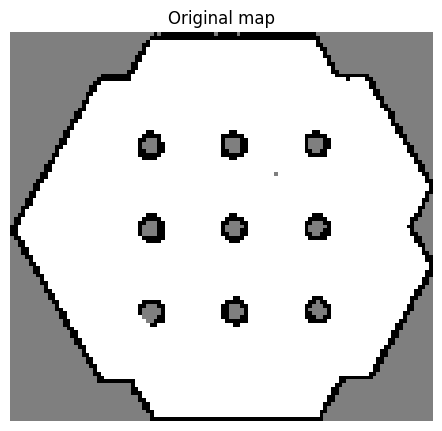

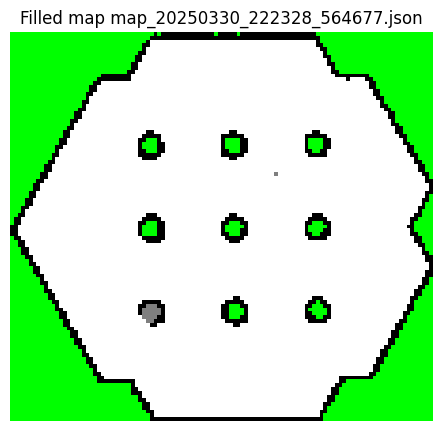

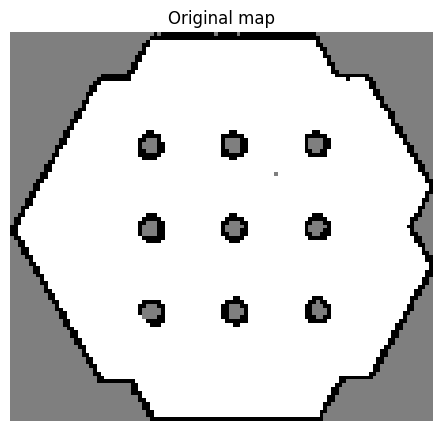

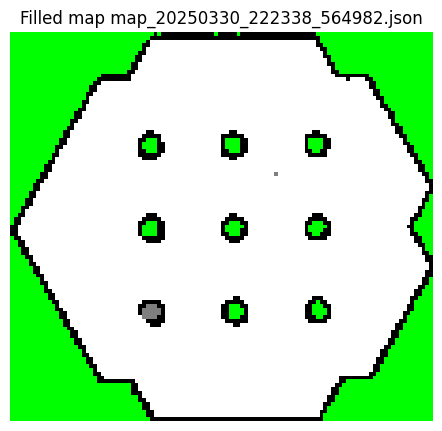

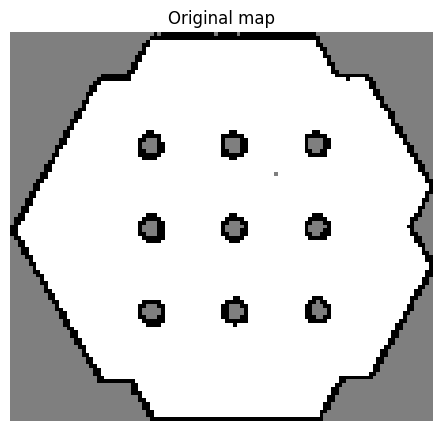

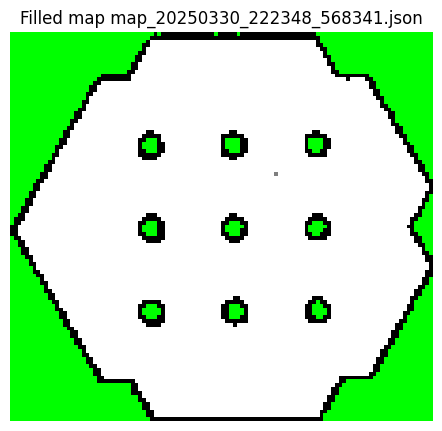

In [61]:
filenames = [_f.name for _f in os.scandir(DIRPATH) if _f.is_file()]
filenames.sort()

for _f in filenames:
    # print(_f)
    _grid, _height, _width = read_data(DIRPATH, _f)
    print_plot(_grid, _height, _width, title="Original map")
    
    filled_grid = fill_enclosed_unknowns_v2(_grid)
    fully_enclised = is_fully_enclosed(filled_grid)
    print(fully_enclised, _f)
    if fully_enclised: filled_grid = fill_outside_with_100(filled_grid)
    print_plot(filled_grid, _height, _width, title=f"Filled map {_f}")
    calculate_remaining_space(filled_grid)
    
    # TODO create fucntion to fill outer space / not calculate the remaining outer space